<a href="https://colab.research.google.com/github/quincynjoroge/MAIZE-CROP-DISEASE-IMAGE-CLASSIFICATION/blob/dev-branch/Copy_of_aug_maize_image_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Load data and libraries

In [6]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [72]:
#loading libraries.
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns

#keras libraries
import keras


#libraries for loading images
from pathlib import Path
import pathlib
import PIL
import PIL.Image

import cv2


# VGG16

In [73]:
#Getting the directory to the train,validation and test data
train_path = '/content/drive/MyDrive/MOG/DATA/Datasets/Augment Images/train'
valid_path = '/content/drive/MyDrive/MOG/DATA/Datasets/Augment Images/valid'
test_path = '/content/drive/MyDrive/MOG/DATA/Datasets/Augment Images/test'


#Preprocessing the data for vgg16 architecture
# Train data
train_batches = tf.keras.preprocessing.image_dataset_from_directory(train_path,image_size=(224,224),batch_size=10)
#Validation data
val_batches = tf.keras.preprocessing.image_dataset_from_directory(valid_path,image_size=(224,224),batch_size=10)

#Test data
test_batches = ImageDataGenerator(preprocessing_function=tf.keras.preprocessing).flow_from_directory(
    directory=test_path, target_size=(224,224), batch_size=10, shuffle=False)

Found 2356 files belonging to 6 classes.
Found 600 files belonging to 6 classes.
Found 120 images belonging to 6 classes.


In [74]:
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input

## Loading VGG16 model
base_model = VGG16(weights="imagenet", include_top=False,input_shape=(224,224,3))
base_model.trainable = False ## Not trainable weights



In [75]:
base_model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_8 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [76]:
x = base_model.layers[-6].output

In [77]:
from tensorflow.keras import layers
from keras.models import Model 

In [79]:
#create an output layer that we're calling output, 
#which will just be a Dense layer with 6 output nodes for the ten corresponding classes,
# we'll use the softmax activation function.

#output = layers.Dense(units=6, activation='softmax')(x)

In [80]:
#construct the new fine-tuned model
#model = keras.models(inputs=base_model.input, outputs=output)

In [81]:
#choose how many layers we actually want to be trained when we train on our new data set.

#we train the last 10 layers
#for layer in model.layers[:-10]:
 #   layer.trainable = False

In [83]:
from tensorflow.keras import layers, models

flatten_layer = layers.Flatten()
dense_layer_1 = layers.Dense(50, activation='relu')
dense_layer_2 = layers.Dense(20, activation='relu')
prediction_layer = layers.Dense(5, activation='softmax')


model = models.Sequential([
    base_model,
    flatten_layer,
    dense_layer_1,
    dense_layer_2,
    prediction_layer
])

In [84]:
#Looking at the model summary to see the new model architecture, along with how the number of trainable parameters.

base_model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_8 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [ ]:
# fit() to train the model
wandb.init(project='maize-image-classification',save_code= True, name='Vgg16',
            config={  # and include hyperparameters and metadata
                     "learning_rate": 0.001,
                     "epochs": 10,
                     "batch_size": 32,
                     "loss_function": "sparse_categorical_crossentropy", #CategoricalCrossentropy
                     "architecture": "VGG16",
                     "dataset": "Maize-Crop-images"
                 })
config = wandb.config 

optimizer = tf.keras.optimizers.Adam(lr=config.learning_rate)
model.compile(optimizer, loss=config.loss_function, metrics=['accuracy'])

history = model.fit(x=train_batches,steps_per_epoch=len(train_batches),validation_data=valid_batches,validation_steps=len(valid_batches),epochs=config.epochs, callbacks=[WandbCallback()],verbose=2)

In [53]:
#compile the model
#wandb.init(project='CNN Classification Model',save_code= True, name='MobileNet_basemodel') 
optimizer = tf.keras.optimizers.Adam(lr=0.0001)
model.compile(optimizer, loss=config.loss_function, metrics=['acc'])

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [ ]:
## Preprocessing input
train_ds = preprocess_input(train_ds) 
test_ds = preprocess_input(val_ds)

In [ ]:
# Add classification head
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(32, 1280)


In [ ]:
#convert these features into a single prediction per image.
prediction_layer = tf.keras.layers.Dense(1)
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(32, 1)


In [ ]:
# build model
inputs = tf.keras.Input(shape=(180, 180, 3))
x = data_augmentation(inputs)
x = normalization_layer(x)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

In [ ]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(lr=base_learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [ ]:
len(model.trainable_variables)

158

In [ ]:
initial_epochs = 10

loss0, accuracy0 = model.evaluate(val_ds)

20/20 [==============================] - 15s 632ms/step - loss: 3.6960 - accuracy: 0.1691


In [ ]:
## Create the base model from the pre-trained model vgg16

image_size=(img_height, img_width)
IMG_SHAPE = image_size + (3,)
## Loading VGG16 model
base_model = VGG16(weights="imagenet", include_top=False,input_shape=IMG_SHAPE)

#freezing
for layer in base_model.layers:
  base_model.trainable = False

global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
prediction_layer = tf.keras.layers.Dense(1)


model = tf.keras.Sequential([
  base_model,
  global_average_layer,
  prediction_layer
])

#Initialize wandb with your project name
run = wandb.init(project='maize-image-classification',save_code=True,name='VGG16',
                 config={  # and include hyperparameters and metadata
                     "learning_rate": 0.0001,
                     "epochs": 20,
                     "batch_size": 32,
                     "loss_function": "BinaryCrossentropy",
                     "architecture": "CNN four layers",
                     "dataset": "maize-images"
                 })
config = wandb.config


optimizer = tf.keras.optimizers.Adam(config.learning_rate) 
model.compile(optimizer, config.loss_function, metrics=['acc'])

# base_learning_rate = 0.0001
# model.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=base_learning_rate),
#               loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
#               metrics=['accuracy'])

# validation_steps=20
# initial_epochs = 20

# loss0,accuracy0 = model.evaluate(validation_batches, steps = validation_steps)

hist= model.fit(train_ds,
          epochs=config.epochs, 
          batch_size=config.batch_size,
          validation_data=(val_ds))

# VGG16 II

In [ ]:
!pip install wandb

In [3]:
import wandb

In [4]:
wandb.login()

<IPython.core.display.Javascript object>

wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [7]:
from keras.layers import Input, Lambda, Dense, Flatten
from keras.models import Model
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
import numpy as np
from glob import glob
import matplotlib.pyplot as plt

# re-size all the images to this
IMAGE_SIZE = [224, 224]

train_path = '/content/drive/MyDrive/MOG/DATA/Datasets/Augment Images/train'
valid_path = '/content/drive/MyDrive/MOG/DATA/Datasets/Augment Images/valid'

# add preprocessing layer to the front of VGG
vgg = VGG16(input_shape=IMAGE_SIZE + [3], weights='imagenet', include_top=False)

# don't train existing weights
for layer in vgg.layers:
  layer.trainable = False

In [18]:
wandb.init(project='maize-image-classification',save_code= True, name='Vgg16',
            config={  # and include hyperparameters and metadata
                     "learning_rate": 0.0001,
                     "epochs": 10,
                     "batch_size": 32,
                     "loss_function": "categorical_crossentropy", #CategoricalCrossentropy
                     "architecture": "VGG16"
                 })
config = wandb.config 

#optimizer = tf.keras.optimizers.Adam(lr=config.learning_rate)
#model.compile(optimizer, loss=config.loss_function, metrics=['accuracy'])

In [19]:
# useful for getting number of classes
folders = glob('/content/drive/MyDrive/MOG/DATA/Datasets/Augment Images/train/*')
  

# our layers - you can add more if you want
x = Flatten()(vgg.output)
# x = Dense(1000, activation='relu')(x)
prediction = Dense(len(folders), activation='softmax')(x)

# create a model object
model = Model(inputs=vgg.input, outputs=prediction)

# view the structure of the model
model.summary()

# tell the model what cost and optimization method to use
model.compile(
  loss=config.loss_function,
  optimizer='adam',
  metrics=['accuracy']
)

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0   

In [15]:
from keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale = 1./255,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)

test_datagen = ImageDataGenerator(rescale = 1./255)

training_set = train_datagen.flow_from_directory('/content/drive/MyDrive/MOG/DATA/Datasets/Augment Images/train',
                                                 target_size = (224, 224),
                                                 batch_size = 32,
                                                 class_mode = 'categorical')

test_set = test_datagen.flow_from_directory('/content/drive/MyDrive/MOG/DATA/Datasets/Augment Images/valid',
                                            target_size = (224, 224),
                                            batch_size = 32,
                                            class_mode = 'categorical')

'''r=model.fit_generator(training_set,
                         samples_per_epoch = 8000,
                         nb_epoch = 5,
                         validation_data = test_set,
                         nb_val_samples = 2000)'''


Found 2999 images belonging to 6 classes.
Found 660 images belonging to 6 classes.


'r=model.fit_generator(training_set,\n                         samples_per_epoch = 8000,\n                         nb_epoch = 5,\n                         validation_data = test_set,\n                         nb_val_samples = 2000)'

In [20]:
# fit the model
r = model.fit(training_set,validation_data=test_set,epochs=config.epochs,steps_per_epoch=len(training_set),validation_steps=len(test_set))

Epoch 1/10
94/94 [==============================] - 1887s 20s/step - loss: 0.8317 - accuracy: 0.7106 - val_loss: 0.5592 - val_accuracy: 0.8227
Epoch 2/10
94/94 [==============================] - 1865s 20s/step - loss: 0.4155 - accuracy: 0.8526 - val_loss: 0.4344 - val_accuracy: 0.8621
Epoch 3/10
94/94 [==============================] - 1863s 20s/step - loss: 0.3177 - accuracy: 0.8893 - val_loss: 0.4341 - val_accuracy: 0.8545
Epoch 4/10
94/94 [==============================] - 1863s 20s/step - loss: 0.2535 - accuracy: 0.9083 - val_loss: 0.4708 - val_accuracy: 0.8561
Epoch 5/10
94/94 [==============================] - 1860s 20s/step - loss: 0.2239 - accuracy: 0.9170 - val_loss: 0.4688 - val_accuracy: 0.8879
Epoch 6/10
94/94 [==============================] - 1861s 20s/step - loss: 0.2044 - accuracy: 0.9330 - val_loss: 0.5179 - val_accuracy: 0.8576
Epoch 7/10
94/94 [==============================] - 1863s 20s/step - loss: 0.1796 - accuracy: 0.9343 - val_loss: 0.4982 - val_accuracy: 0.8606

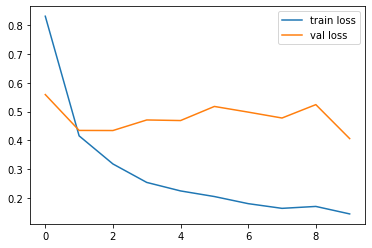

<Figure size 432x288 with 0 Axes>

In [21]:
# loss
plt.plot(r.history['loss'], label='train loss')
plt.plot(r.history['val_loss'], label='val loss')
plt.legend()
plt.show()
plt.savefig('LossVal_loss')

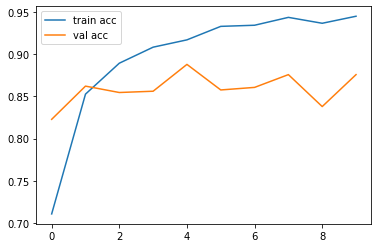

<Figure size 432x288 with 0 Axes>

In [22]:
# accuracies
plt.plot(r.history['accuracy'], label='train acc')
plt.plot(r.history['val_accuracy'], label='val acc')
plt.legend()
plt.show()
plt.savefig('AccVal_acc')

In [23]:
import tensorflow as tf

from keras.models import load_model

model.save('imageclass_new_model')

INFO:tensorflow:Assets written to: imageclass_new_model/assets
